In [149]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import os
from src import config

In [150]:
features_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "pairwise_sessions_features_df.pkl"))
labels_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "pairwise_sessions_labels_df.pkl"))

In [151]:
# Remove all the features that are not contains 'Pre' in their name
features_df = features_df.loc[:, ~features_df.columns.str.contains('Post')]

# Remove all the features that are contains 'SQRT' in their name
features_df = features_df.loc[:, ~features_df.columns.str.contains('SQRT')]

# Remove all the features that are start with 'Distance' in their name
features_df = features_df.loc[:, ~features_df.columns.str.startswith('Distance')]

# Change the names of the features to be more readable-
# remove the suffix '_Pre'
features_df.columns = [col.replace('_Pre', '') for col in features_df.columns]

# Take all the features that start with 'DVA', and add the suffix '_Distance' to them
features_df.columns = [col + '_Distance' if col.startswith('DVA') else col for col in features_df.columns]
features_df.columns = [col.replace('DVA_', '') for col in features_df.columns]

# Replace '_' with ' ' (space)
features_df.columns = [col.replace('_', ' ') for col in features_df.columns]

features_df.head()

,Movie,Gaze Counts In RoI,Gaze Counts Out RoI,Gaze In out RoI Ratio,Gaze Re Entries To RoI Count,Gaze Re Entries To RoI Rate,Gaze Mean Pupil Percentage Change On Event,Fixations Counts In RoI,Fixations Counts Out RoI,Fixations In out RoI Ratio,...,Min Gaze Distance,Sem Gaze Distance,AUC Gaze Distance,Mean Fixations Distance,Median Fixations Distance,Std Fixations Distance,Max Fixations Distance,Min Fixations Distance,Sem Fixations Distance,AUC Fixations Distance
0,20,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-0.875,NaN,...,0.883197,-0.411114,-0.217807,-0.155891,-0.214334,-0.164944,-0.178732,0.1268,0.576611,-0.894486
1,42,0.344156,-0.011398,0.351631,0.25,0.25,NaN,0.0,0.222222,-0.222222,...,NaN,-0.346106,-0.173843,-0.155457,-0.137816,-0.249335,-0.216096,0.202929,-0.335424,0.071943
2,20,-0.975983,0.126593,-0.979023,-0.6,-0.6,NaN,-1.0,0.16,-1.0,...,-1.0,-0.297209,0.123881,0.106083,0.050353,-0.388821,-0.018406,0.335309,-0.413777,0.177596
3,29,-1.0,0.043057,-1.0,-1.0,-1.0,NaN,-1.0,0.105263,-1.0,...,NaN,-0.340974,0.13706,0.081928,0.042695,-0.414498,0.027018,0.532861,-0.438085,0.154407
4,58,-1.0,0.059991,-1.0,-1.0,-1.0,NaN,-1.0,-0.962963,-1.0,...,0.720665,-0.946719,-0.049187,0.012744,-0.035617,NaN,-0.243181,0.741438,NaN,-0.965072


In [152]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4352 entries, 0 to 4351
Data columns (total 76 columns):
 #   Column                                           Non-Null Count  Dtype 
---  ------                                           --------------  ----- 
 0   Movie                                            4352 non-null   int8  
 1   Gaze Counts In RoI                               3088 non-null   object
 2   Gaze Counts Out RoI                              4352 non-null   object
 3   Gaze In out RoI Ratio                            3088 non-null   object
 4   Gaze Re Entries To RoI Count                     3088 non-null   object
 5   Gaze Re Entries To RoI Rate                      3088 non-null   object
 6   Gaze Mean Pupil Percentage Change On Event       0 non-null      object
 7   Fixations Counts In RoI                          2472 non-null   object
 8   Fixations Counts Out RoI                         4342 non-null   object
 9   Fixations In out RoI Ratio               

In [153]:
labels_df.head()

,normalized_by_session_a
series_id,
0,1
1,1
2,1
3,0
4,1


In [154]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4352 entries, 0 to 4351
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   normalized_by_session_a  4352 non-null   int64
dtypes: int64(1)
memory usage: 68.0 KB


Data Cleaning

how many missing values / inf values are there in each column? show the top 10

In [155]:
print('Number of missing values in each column:', features_df.isin([np.nan, np.inf, -np.inf]).sum(axis=0).sort_values(ascending=False).head(10))

Number of missing values in each column: Fixations Mean Pupil Percentage Change On Event    4352
Gaze Mean Pupil Percentage Change On Event         4352
onset Std Saccades Start In RoI                    2858
onset Sem Saccades Start In RoI                    2858
Pupil radius Fixations ReEntry Mean Diff           2846
Pupil radius Fixations First Diff                  2840
onset Std Fixations In RoI                         2780
onset Sem Fixations In RoI                         2780
last onset Std Saccades End In RoI                 2762
last onset Sem Saccades End In RoI                 2762
dtype: int64


Remove columns with more than 30% missing values or inf values

In [156]:
features_df = features_df.loc[:, features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=0) < 0.3]

In [157]:
features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=0).sort_values(ascending=False).head(10)

Gaze In out RoI Ratio           0.290441
Gaze Re Entries To RoI Count    0.290441
Gaze Re Entries To RoI Rate     0.290441
Gaze Counts In RoI              0.290441
Min Gaze Distance               0.249081
Sem Fixations Distance          0.005974
Std Fixations Distance          0.005974
AUC Fixations Distance          0.003217
Mean Fixations Distance         0.003217
Min Fixations Distance          0.003217
dtype: float64

how many missing values / inf values are there in each row? show the top 10

In [158]:
features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=1).sort_values(ascending=False).head(10)

855     0.608696
1839    0.608696
3245    0.608696
2240    0.608696
2985    0.478261
2537    0.478261
1473    0.434783
3924    0.434783
2901    0.434783
440     0.434783
dtype: float64

Remove rows with more than 50% missing values

In [159]:
features_df = features_df.loc[features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=1) < 0.5]
# remove the corresponding rows from y_train
labels_df = labels_df.loc[labels_df.index.isin(features_df.index)]

In [160]:
features_df.isin([np.nan, np.inf, -np.inf]).mean(axis=1).sort_values(ascending=False).head(10)

2985    0.478261
2537    0.478261
440     0.434783
3924    0.434783
2901    0.434783
1473    0.434783
3833    0.304348
2816    0.304348
3863    0.304348
550     0.304348
dtype: float64

Subject-wise or leave-one-subject-out (LOSO) cross-validation

Leave-One-Subject-Out Cross-Validation (LOSO CV):
- For each fold of the cross-validation, data from N-1 participants are used for training, and the data from the remaining participant is used for testing.
- This process is repeated N times (for each participant), ensuring that each participant's data is used as a test set exactly once.
- This method ensures that the model generalizes well across different participants.

In [161]:
series_id_df = pd.read_pickle(os.path.join(config.classification_resource_dir, "pairwise_sessions_series_id_df.pkl"))

# remove the corresponding rows from y_train
series_id_df = series_id_df.loc[series_id_df.index.isin(features_df.index)]

# Create a list of unique subject IDs
subject_ids = series_id_df[config.SUBJECT].unique()

# Order the list of subject IDs alphabetically
subject_ids = np.sort(subject_ids)

# Create groups of subject IDs
groups = series_id_df[config.SUBJECT].values

# Print the groups
print(groups)

['SM28' 'BB30' 'TA01' ... 'BO03' 'AJ31' 'HB81']


In [162]:
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [163]:
def logistic_regression_model_searcher():
    # Define the range of values for each hyperparameter
    C = np.linspace(0.01, 1, 15)
    PENALTY = ['l1', 'l2']
    SOLVER = ['liblinear', 'saga']
    
    LR_PARAM_GRID  = {
        'C': C,
        'penalty': PENALTY,
        'solver': SOLVER
    }
    
    return GridSearchCV(estimator=LogisticRegression(), param_grid=LR_PARAM_GRID, verbose=0)


In [164]:
# Gradient Boosting:

def gradient_boosting_model_searcher():
    # Define the range of values for each hyperparameter
    LEARNING_RATE = np.linspace(0.05, 0.5, 5)
    MAX_DEPTH = range(2, 4)
    N_ESTIMATORS = range(100, 150, 5)
    
    GB_PARAM_GRID  = {
        'learning_rate': LEARNING_RATE,
        'max_depth': MAX_DEPTH,
        'n_estimators': N_ESTIMATORS
    }
    
    return GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=GB_PARAM_GRID, verbose=0)

In [165]:
# SVM:

def svm_model_searcher():
    # Define the range of values for each hyperparameter
    C = np.linspace(0.01, 1, 10)
    KERNEL = ['linear', 'poly', 'rbf', 'sigmoid']
    GAMMA = ['scale', 'auto']
    
    SVM_PARAM_GRID  = {
        'C': C,
        'kernel': KERNEL,
        'gamma': GAMMA
    }
    
    return GridSearchCV(estimator=SVC(), param_grid=SVM_PARAM_GRID, verbose=0)

In [166]:
# Random Forest:

def random_forest_model_searcher():
    # Define the range of values for each hyperparameter
    N_ESTIMATORS = range(50, 140, 10)
    MAX_DEPTH = range(2, 5)
    MIN_SAMPLES_SPLIT = range(2, 4)
    MIN_SAMPLES_LEAF = range(1, 3)
    
    RF_PARAM_GRID  = {
        'n_estimators': N_ESTIMATORS,
        'max_depth': MAX_DEPTH,
        'min_samples_split': MIN_SAMPLES_SPLIT,
        'min_samples_leaf': MIN_SAMPLES_LEAF
    }
    
    return GridSearchCV(estimator=RandomForestClassifier(), param_grid=RF_PARAM_GRID, verbose=0)

In [167]:
# XGBoost model

def xgboost_model_searcher():
    # Define the range of values for each hyperparameter
    LEARNING_RATE = np.linspace(0.05, 0.5, 5)
    MAX_DEPTH = range(2, 5)
    N_ESTIMATORS = range(100, 150, 5)
    
    XGB_PARAM_GRID  = {
        'learning_rate': LEARNING_RATE,
        'max_depth': MAX_DEPTH,
        'n_estimators': N_ESTIMATORS
    }
    
    return GridSearchCV(estimator=XGBClassifier(), param_grid=XGB_PARAM_GRID, verbose=0)

In [168]:
classifiers = {
    # 'SVM': svm_model_searcher(),
    # 'Gradient Boosting': gradient_boosting_model_searcher(),
    # 'Random Forest': random_forest_model_searcher(),
    # 'Logistic Regression': logistic_regression_model_searcher(),
    'XGBoost': xgboost_model_searcher()
}

In [169]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(model_name, y_test, y_pred):
    # Evaluate the model using various metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(model_name)
    # Print the evaluation metrics
    print("Accuracy:", round(accuracy, 2))
    print("Precision:", round(precision, 2))
    print("Recall:", round(recall, 2))
    print("F1-score:", round(f1, 2))
    print("ROC-AUC score:", round(roc_auc, 2))

    # Compute the confusion matrix in average format (i.e., divide by the number of samples with the corresponding label)
    confusion_mat = confusion_matrix(y_test, y_pred, normalize='true') * 100
    # round the values in the confusion matrix
    confusion_mat = np.round(confusion_mat).astype(int)
    
    # Create a heatmap visualization of the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d", ax=ax)

    # Set the axis labels and title
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    ax.set_title("Confusion Matrix")

    # Show the plot
    plt.show()
    
    return confusion_mat

XGBoost on AI09
Accuracy: 0.56
Precision: 0.56
Recall: 0.55
F1-score: 0.56
ROC-AUC score: 0.56


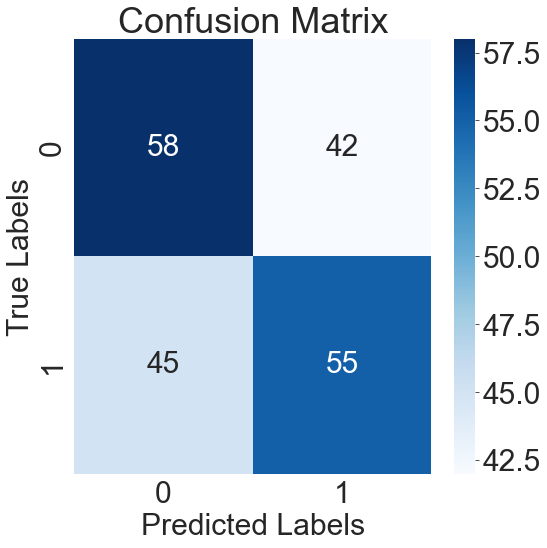

XGBoost on AJ31
Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1-score: 0.67
ROC-AUC score: 0.67


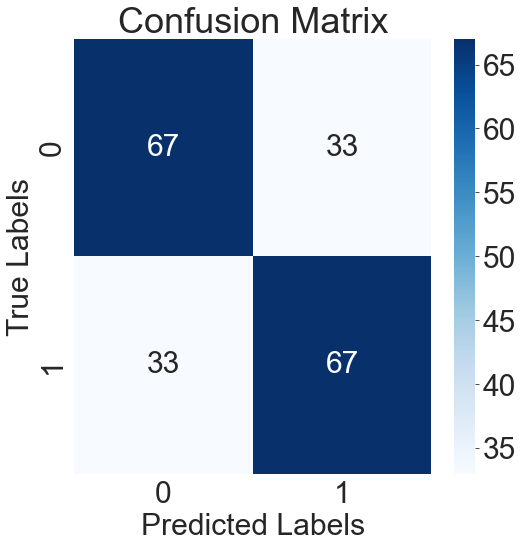

XGBoost on AM45
Accuracy: 0.82
Precision: 0.82
Recall: 0.83
F1-score: 0.82
ROC-AUC score: 0.82


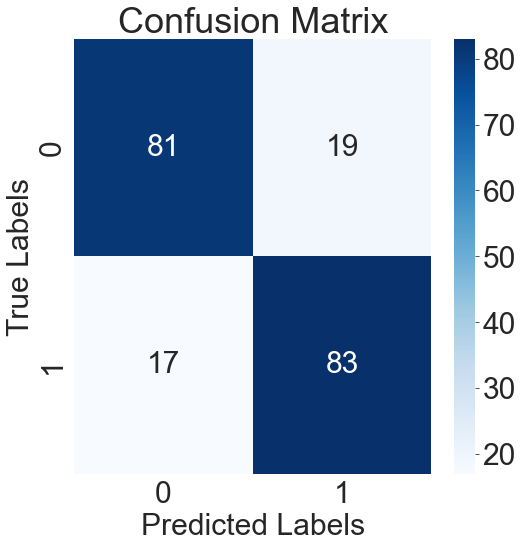

XGBoost on AS20
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1-score: 0.86
ROC-AUC score: 0.86


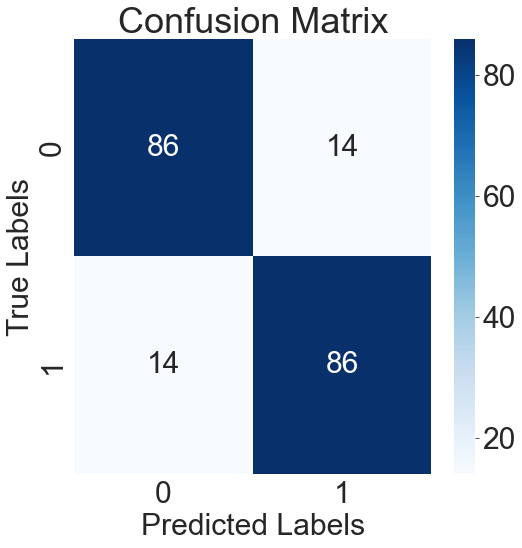

XGBoost on BB30
Accuracy: 0.48
Precision: 0.48
Recall: 0.5
F1-score: 0.49
ROC-AUC score: 0.48


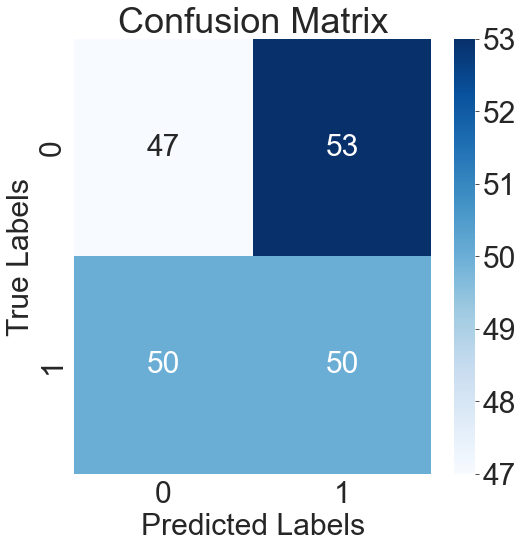

XGBoost on BG97
Accuracy: 0.45
Precision: 0.45
Recall: 0.45
F1-score: 0.45
ROC-AUC score: 0.45


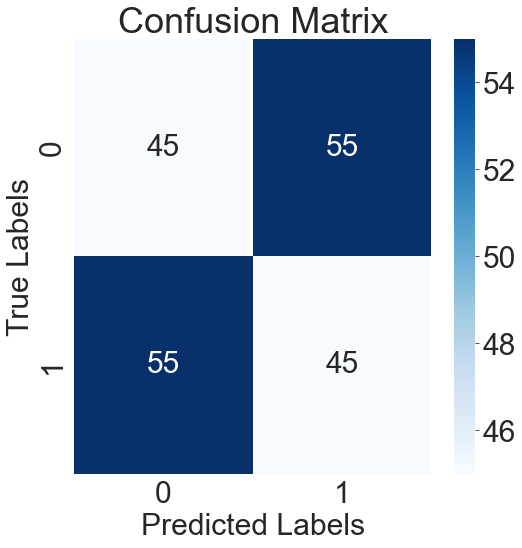

XGBoost on BH27
Accuracy: 0.55
Precision: 0.55
Recall: 0.55
F1-score: 0.55
ROC-AUC score: 0.55


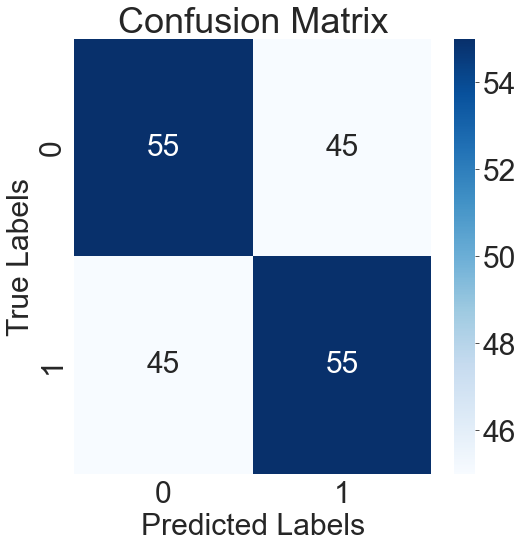

XGBoost on BO03
Accuracy: 0.82
Precision: 0.82
Recall: 0.83
F1-score: 0.82
ROC-AUC score: 0.82


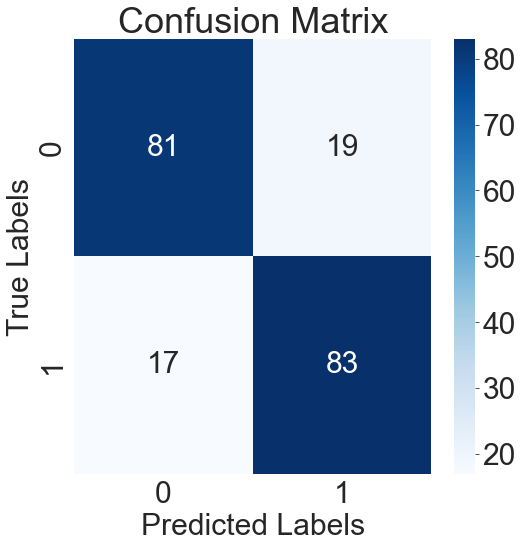

XGBoost on CR06
Accuracy: 0.77
Precision: 0.77
Recall: 0.78
F1-score: 0.78
ROC-AUC score: 0.77


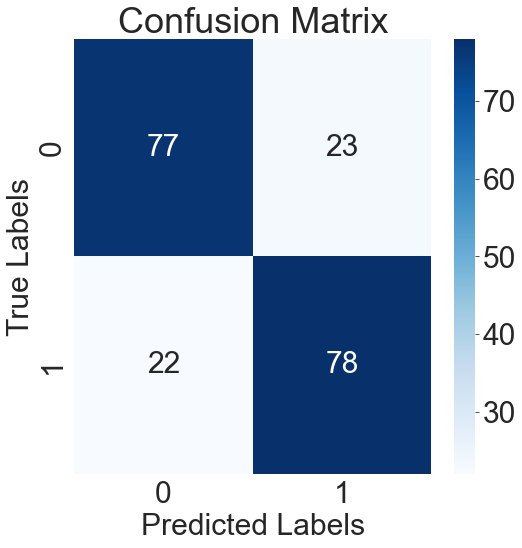

XGBoost on DK47
Accuracy: 0.69
Precision: 0.69
Recall: 0.69
F1-score: 0.69
ROC-AUC score: 0.69


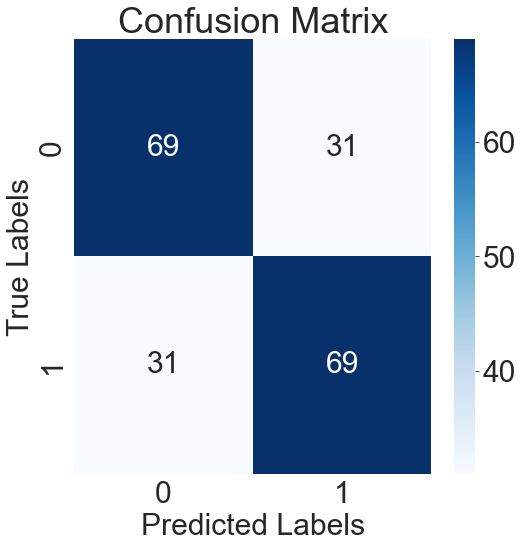

XGBoost on FY25
Accuracy: 0.67
Precision: 0.67
Recall: 0.69
F1-score: 0.68
ROC-AUC score: 0.67


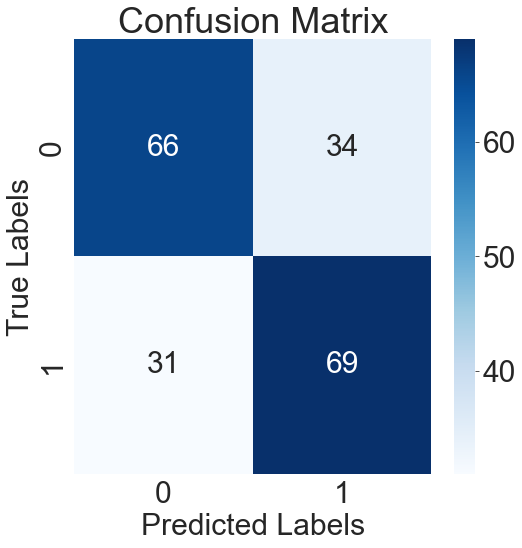

XGBoost on GE44
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1-score: 0.75
ROC-AUC score: 0.75


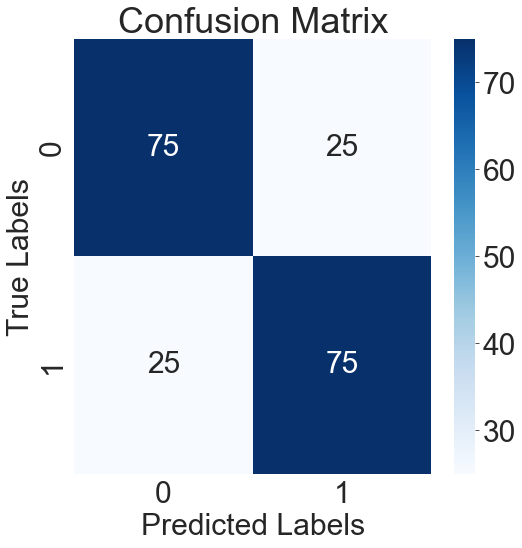

XGBoost on GN10
Accuracy: 0.65
Precision: 0.65
Recall: 0.64
F1-score: 0.65
ROC-AUC score: 0.65


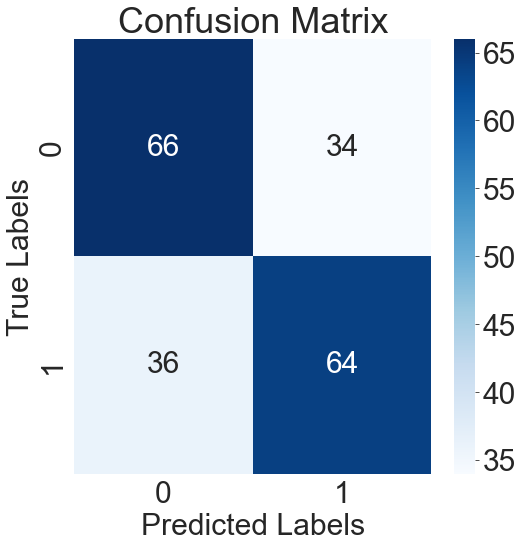

XGBoost on HB81
Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1-score: 0.72
ROC-AUC score: 0.72


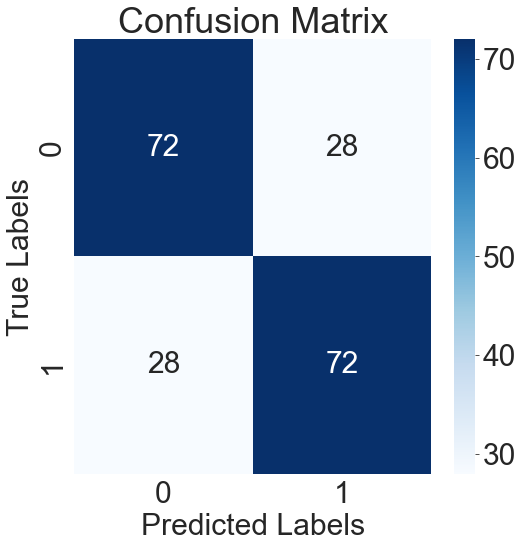

XGBoost on HM02
Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1-score: 0.72
ROC-AUC score: 0.72


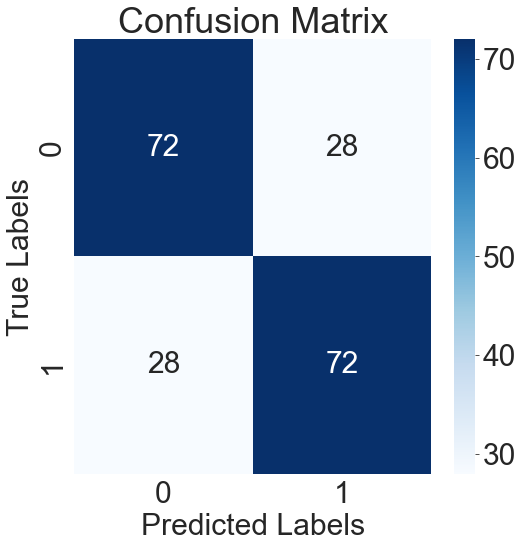

XGBoost on HR58
Accuracy: 0.9
Precision: 0.89
Recall: 0.91
F1-score: 0.9
ROC-AUC score: 0.9


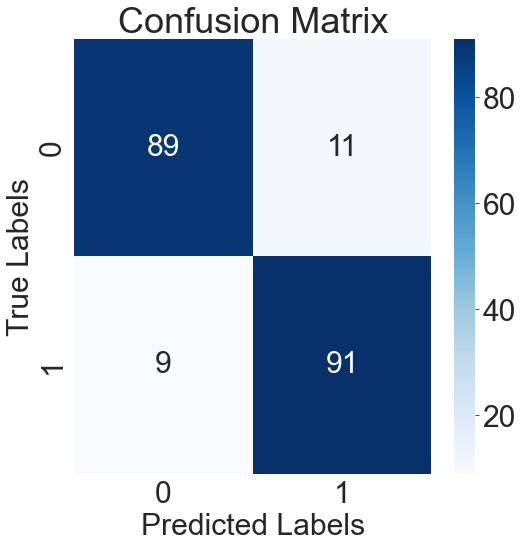

XGBoost on KL89
Accuracy: 0.69
Precision: 0.69
Recall: 0.69
F1-score: 0.69
ROC-AUC score: 0.69


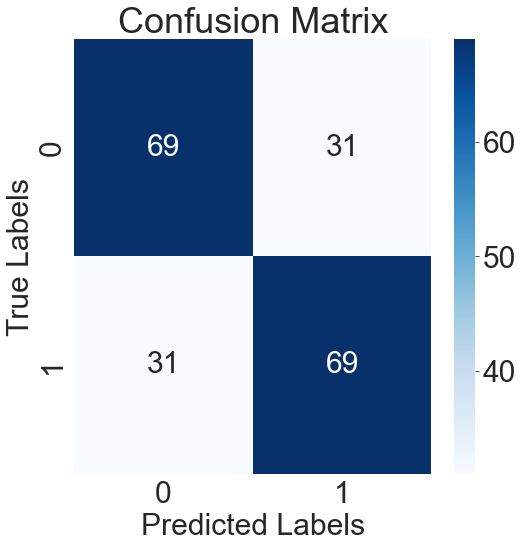

XGBoost on KM28
Accuracy: 0.62
Precision: 0.62
Recall: 0.62
F1-score: 0.62
ROC-AUC score: 0.62


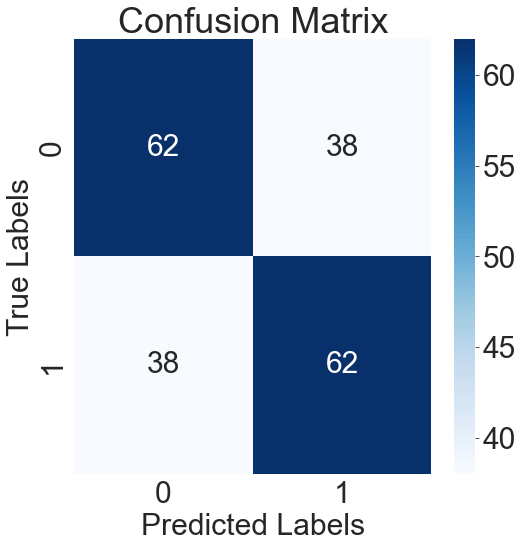

XGBoost on KR13
Accuracy: 0.73
Precision: 0.73
Recall: 0.72
F1-score: 0.72
ROC-AUC score: 0.73


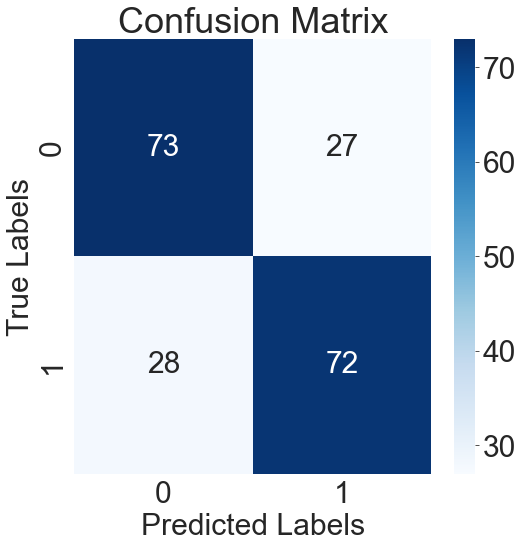

XGBoost on MA40
Accuracy: 0.65
Precision: 0.65
Recall: 0.64
F1-score: 0.65
ROC-AUC score: 0.65


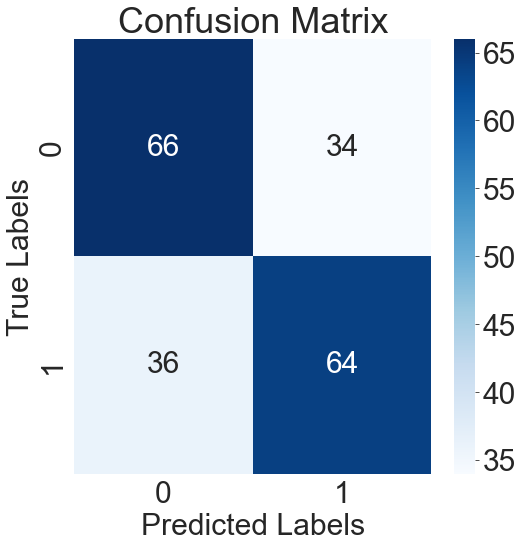

XGBoost on MN01
Accuracy: 0.66
Precision: 0.67
Recall: 0.66
F1-score: 0.66
ROC-AUC score: 0.66


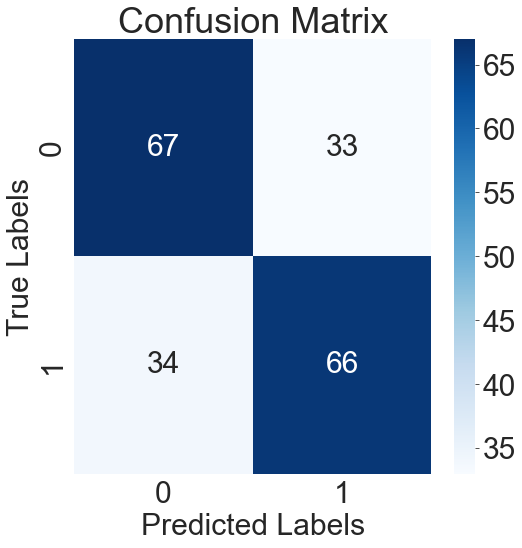

XGBoost on MN37
Accuracy: 0.62
Precision: 0.62
Recall: 0.62
F1-score: 0.62
ROC-AUC score: 0.62


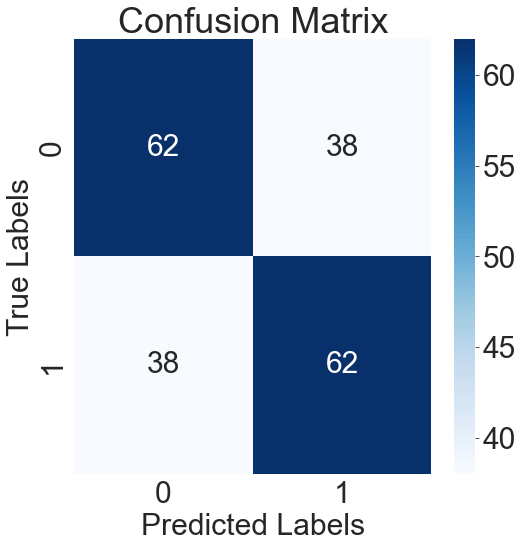

XGBoost on NN81
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1-score: 0.86
ROC-AUC score: 0.86


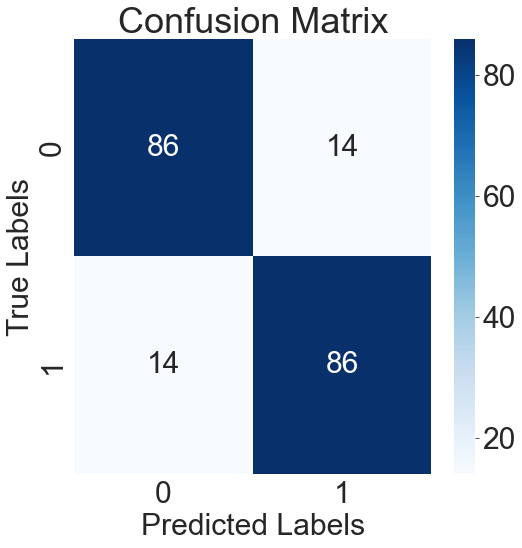

XGBoost on NY90
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1-score: 0.75
ROC-AUC score: 0.75


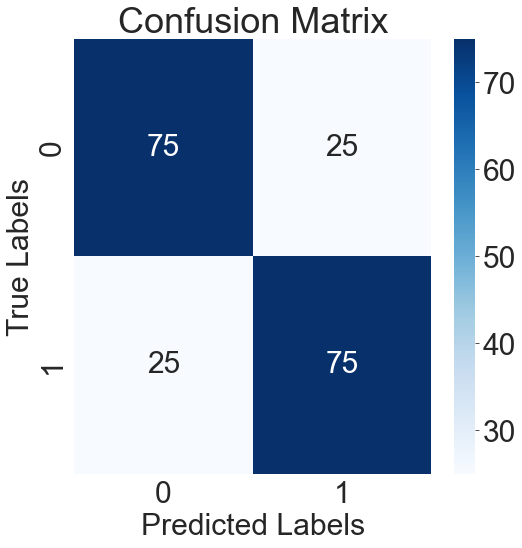

XGBoost on PM15
Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1-score: 0.89
ROC-AUC score: 0.89


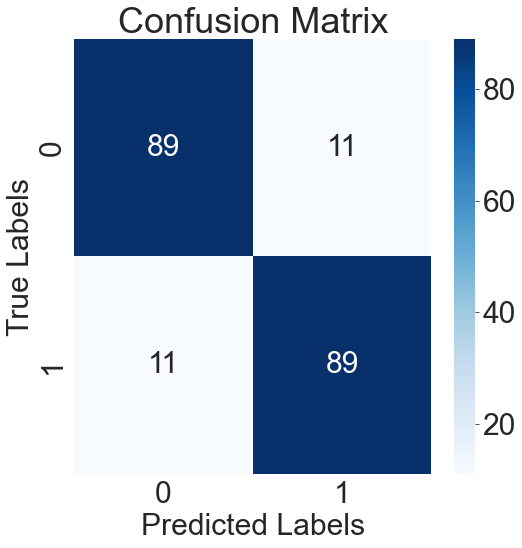

XGBoost on PS08
Accuracy: 0.57
Precision: 0.57
Recall: 0.58
F1-score: 0.57
ROC-AUC score: 0.57


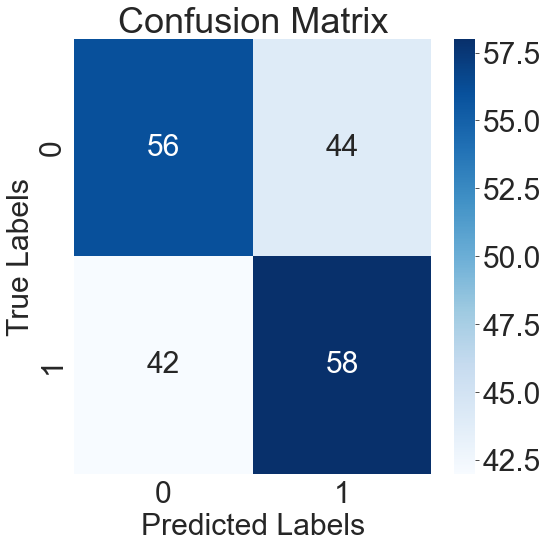

XGBoost on RN85
Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-score: 0.91
ROC-AUC score: 0.91


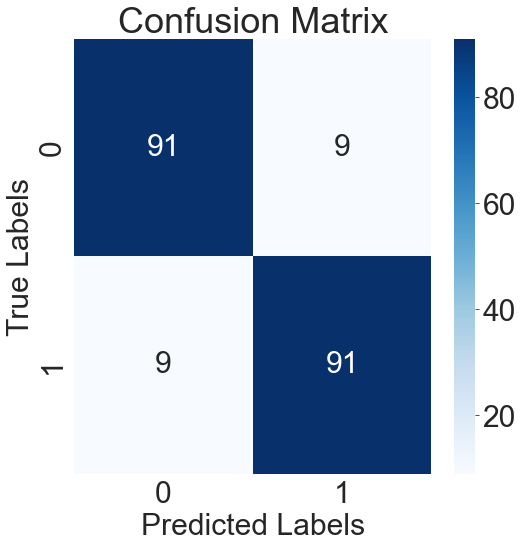

XGBoost on RS30
Accuracy: 0.65
Precision: 0.65
Recall: 0.66
F1-score: 0.65
ROC-AUC score: 0.65


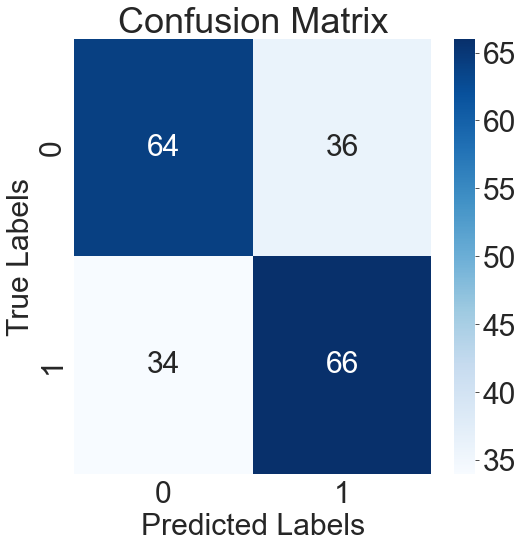

XGBoost on RY20
Accuracy: 0.58
Precision: 0.58
Recall: 0.58
F1-score: 0.58
ROC-AUC score: 0.58


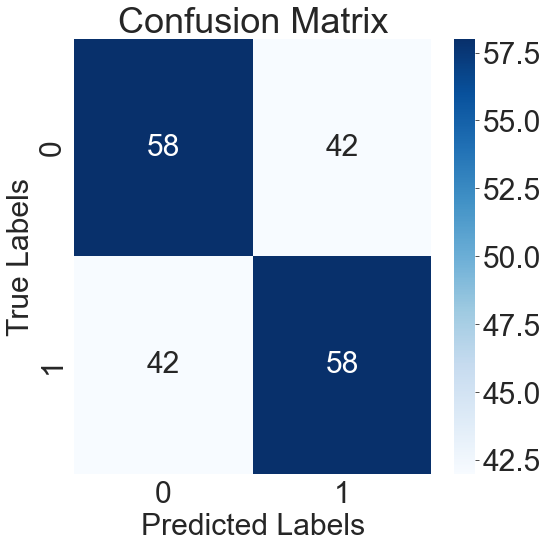

XGBoost on SM28
Accuracy: 0.51
Precision: 0.51
Recall: 0.52
F1-score: 0.51
ROC-AUC score: 0.51


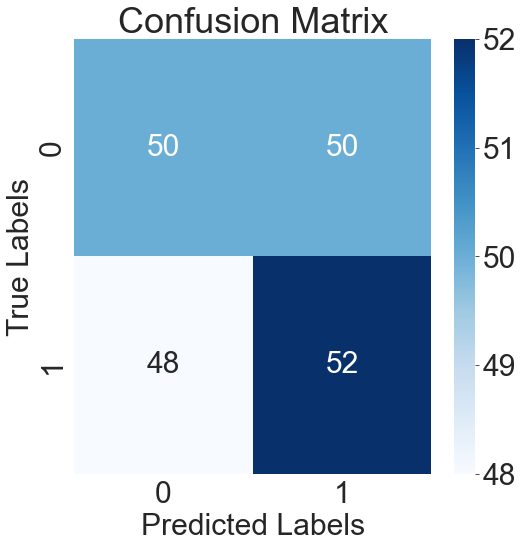

XGBoost on TA01
Accuracy: 0.61
Precision: 0.61
Recall: 0.61
F1-score: 0.61
ROC-AUC score: 0.61


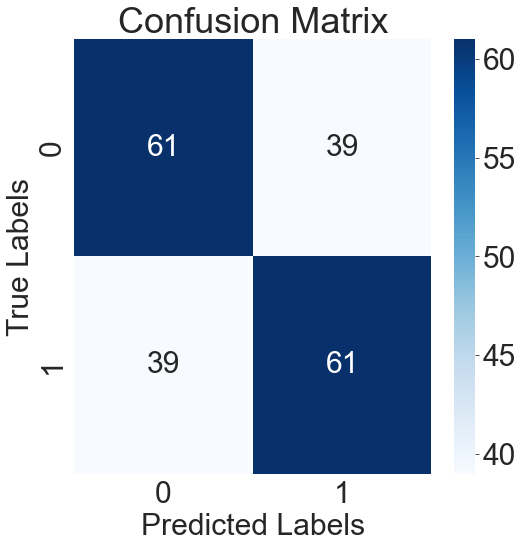

XGBoost on WE10
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1-score: 0.75
ROC-AUC score: 0.75


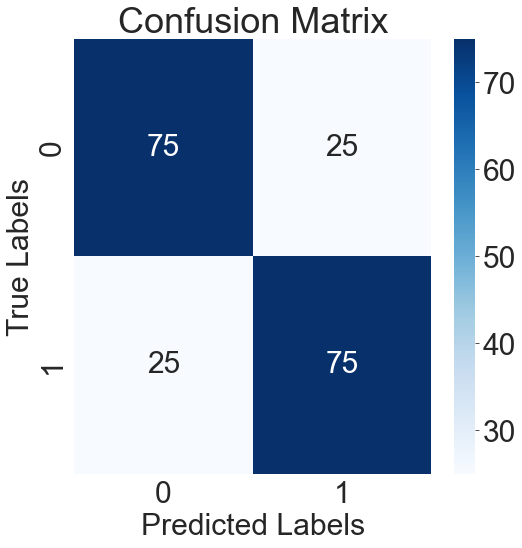

XGBoost on ZN05
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1-score: 0.77
ROC-AUC score: 0.77


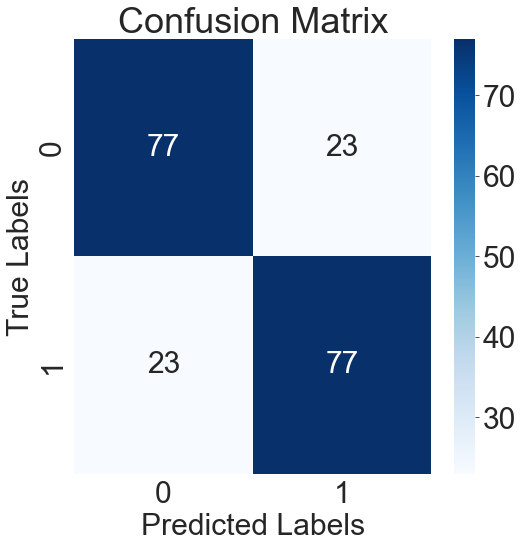

XGBoost on ZW57
Accuracy: 0.74
Precision: 0.74
Recall: 0.74
F1-score: 0.74
ROC-AUC score: 0.74


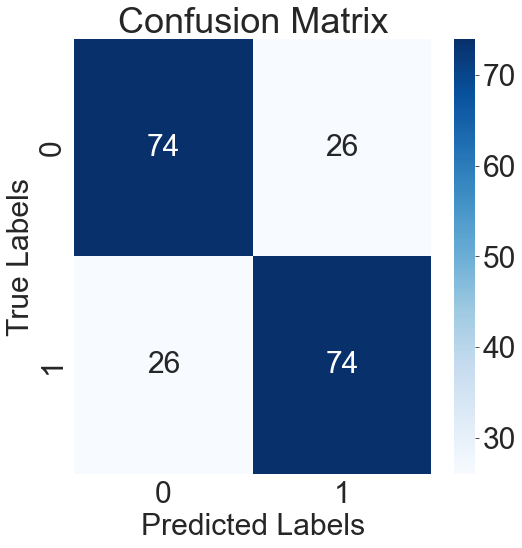

Average accuracy of XGBoost: 0.6953
Average confusion matrix of XGBoost: [[69.44117647 30.55882353]
 [30.26470588 69.73529412]]

The best classifier is: XGBoost with accuracy: 0.6953


In [170]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap

# Initialize LeaveOneSubjectOut cross-validator
logo = LeaveOneGroupOut()

# Function to perform LOSO CV and return average accuracy
def evaluate_classifier(model_searcher, X, y, groups, name):
    accuracies = {}
    confusion_matricies = {}
    confidence_intervals = {}
    models = {}
    roc_auc_curves = {}
    shap_values_dict = {}

    for train_index, test_index in logo.split(X, y, groups):
        # Extract indices for training and testing data for each participant
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # fill inf values with the mean of the column
        X_train = X_train.replace(np.inf, 2)
        X_test = X_test.replace(np.inf, 2)
        X_train = X_train.replace(-np.inf, -2)
        X_test = X_test.replace(-np.inf, -2)
        
        X_train = X_train.fillna(X_train.median())
        X_test = X_test.fillna(X_train.median())

        # Scale the data
        # Create separate StandardScaler instances
        scaler_x = StandardScaler()
        # Fit on Training Data (!)
        scaler_x.fit(X_train.values)
        # Transform both training and testing data
        X_train_scaled = scaler_x.transform(X_train.values)
        X_test_scaled = scaler_x.transform(X_test.values)
        y_train = y_train.values.reshape(-1, 1).flatten()
        y_test = y_test.values.reshape(-1, 1).flatten()
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

        model_searcher.fit(X_train_scaled, y_train)
        clf = model_searcher.best_estimator_

        # Fit the classifier
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        # Store the results for this fold using subject name as key
        subject_name = groups[test_index[0]]
        accuracies[subject_name] = acc
        conf_mat = evaluate_model(f"{name} on {subject_name}", y_test, y_pred)
        confusion_matricies[subject_name] = conf_mat
        models[subject_name] = clf
        confidence_intervals[subject_name] = (acc - 1.96 * np.sqrt(acc * (1 - acc) / len(y_test)), acc + 1.96 * np.sqrt(acc * (1 - acc) / len(y_test)))
        roc_auc_curves[subject_name] = y_test, clf.predict_proba(X_test_scaled)[:, 1]

        # Calculate Shap values
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_test_scaled)
        shap_values_dict[subject_name] = shap_values
        
    # return all the computed dictionaries
    return accuracies, confusion_matricies, confidence_intervals, models, roc_auc_curves, shap_values_dict

# Evaluate each classifier
results = {}
for name, clf in classifiers.items():
    acc, confusion_matricies, confidence_intervals, models, roc_auc_curves, shap_values_dict = evaluate_classifier(clf, features_df, labels_df, groups, name)
    avg_confusion_matrix = np.mean(list(confusion_matricies.values()), axis=0)
    avg_acc = np.mean(list(acc.values())) 

    results[name] = avg_acc, avg_confusion_matrix, acc, confusion_matricies, confidence_intervals, models, roc_auc_curves, shap_values_dict
    print(f"Average accuracy of {name}: {avg_acc:.4f}")
    print(f"Average confusion matrix of {name}: {avg_confusion_matrix}")

# Decision-making (choose the classifier with the highest average accuracy)
best_classifier_name = max(results, key=lambda k: results[k][0])
print(f"\nThe best classifier is: {best_classifier_name} with accuracy: {results[best_classifier_name][0]:.4f}")

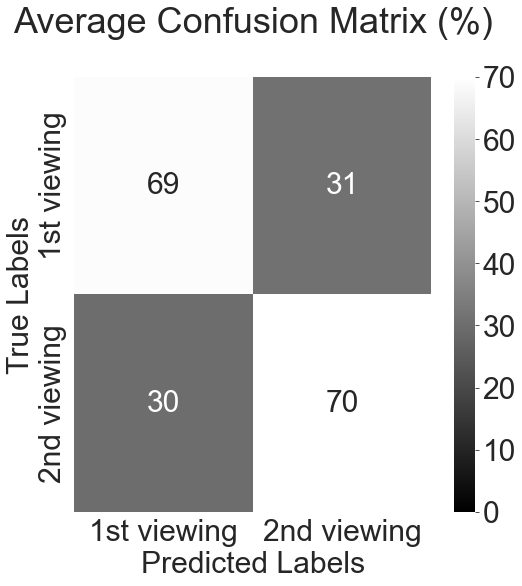

In [171]:
# Plot the average confusion matrix
# round the values in the confusion matrix
avg_confusion_matrix_round = np.round(results[best_classifier_name][1]).astype(int)

# Create a heatmap visualization of the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
# the color range should start at 0 and end at the maximum value in the confusion matrix
sns.heatmap(avg_confusion_matrix_round, annot=True, cmap="gray", fmt="d", ax=ax, vmin=0, vmax=np.max(avg_confusion_matrix_round))

# Set the axis values- replace 0 with 1st viewing and 1 with 2nd viewing
ax.set_xticklabels(['1st viewing', '2nd viewing'])
ax.set_yticklabels(['1st viewing', '2nd viewing'])


# Set the axis labels and title
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Average Confusion Matrix (%)\n")

# Style
# Make the fonts visible in the plot
plt.rcParams.update({'font.size': 26})
# Make the tick labels of the heatmap visible
for tick in ax.get_xticklabels():
    tick.set_visible(True)
for tick in ax.get_yticklabels():
    tick.set_visible(True)
    
# Save the plot
plt.savefig(os.path.join(config.classification_resource_dir, "confusion_matrix.svg"), bbox_inches='tight')

# Show the plot
plt.show()

Calculating ROC AUC for each participant (fold)

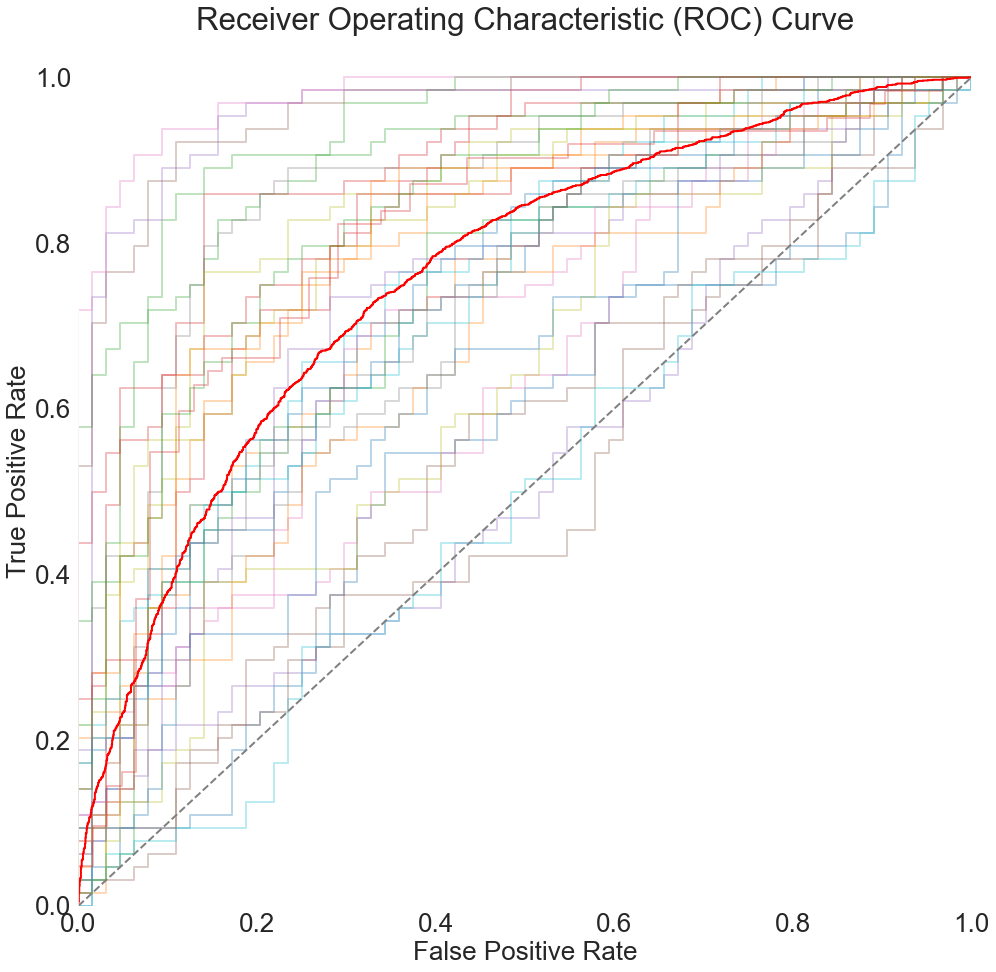

In [172]:
from sklearn.metrics import roc_curve, auc

roc_auc_curves = results[best_classifier_name][6]

# Plot ROC curve for each participant
fig, ax = plt.subplots(figsize=(16, 16))

# For each fold calculate ROC curve and ROC area
for subject_name, (y_test, y_pred) in roc_auc_curves.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve with transparency
    ax.plot(fpr, tpr, lw=2, alpha=0.3, label=f'ROC curve of {subject_name} (area = {roc_auc:.2f})')
    
# Plot ROC curve for average classifier with error bars representing 95% confidence intervals
y_test, y_pred = np.concatenate([y_test for y_test, y_pred in roc_auc_curves.values()]), np.concatenate([y_pred for y_test, y_pred in roc_auc_curves.values()])
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve of average classifier (area = {roc_auc:.2f})')

# Plot ROC curve for random classifier
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

# Set the limits of the plot to include both curves
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

# Set the axis labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
# Without legends
# ax.legend(loc="lower right")

# Transparent background
ax.patch.set_alpha(0.0)

# Save the plot
plt.savefig(os.path.join(config.classification_resource_dir, "roc_auc.svg"), bbox_inches='tight')

# Show the plot
plt.show()

Calculating Performance Across Participants (Subject-wise)

The Y-axis can represent the accuracy for each participant, i.e., the percentage of correct classifications. This is the most direct measure of classifier performance and would be readily interpretable by most readers. We can use error bars to represent confidence intervals for each participant's accuracy.

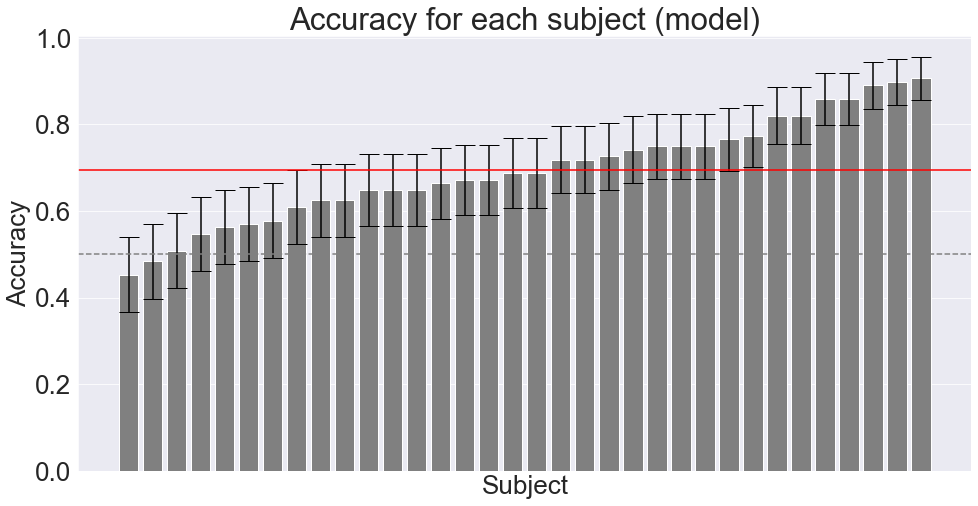

In [173]:
acc = results[best_classifier_name][2]
confidence_intervals = results[best_classifier_name][4]
avg_acc = results[best_classifier_name][0]

# Plot the accuracy for each participant with wide error bars representing 95% confidence intervals for each participant
fig, ax = plt.subplots(figsize=(16, 8))
# Sort the accuracies dictionary by value (accuracy) and plot the values
# Color the bars according to the confidence intervals in grays
ax.bar(sorted(acc, key=acc.get), [acc[key] for key in sorted(acc, key=acc.get)], color='gray', yerr=[[acc[key] - confidence_intervals[key][0] for key in sorted(acc, key=acc.get)], [confidence_intervals[key][1] - acc[key] for key in sorted(acc, key=acc.get)]], capsize=10)
ax.set_xlabel("Subject")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy for each subject (model)")
# remove the ticks from the x-axis
ax.set_xticks([])

# Add a horizontal dashed line representing the average accuracy across participants
ax.axhline(y=avg_acc, color='r', linestyle='-')
# Add horizontal lines representing the chance level accuracy (50%) and the perfect accuracy (100%)
ax.axhline(y=0.5, color='gray', linestyle='--')

# Increase font size
plt.rcParams.update({'font.size': 25})
# Save the plot
plt.savefig(os.path.join(config.classification_resource_dir, "accuracy_distribution.svg"), bbox_inches='tight')
# Show the plot
plt.show()

Take the best model and train it on the whole dataset

The best model is SVM, so we will train it on the whole dataset, using the average hyperparameters from the LOSO CV

In [174]:
# Get the best model
best_model = results[best_classifier_name][5]

# Go over all the models and average the hyperparameters
best_model_params = {}
for model in best_model.values():
    for param, value in model.get_params().items():
        # If parameter is numeric, add it to the dictionary
        if isinstance(value, (int, float)):
            # if the parameter is already in the dictionary, append the value to the list
            if param in best_model_params:
                best_model_params[param].append(value)
            else:
                best_model_params[param] = [value]
for param, value in best_model_params.items():
    best_model_params[param] = np.mean(value)

best_model_params

{'enable_categorical': 0.0,
 'learning_rate': 0.06985294117647059,
 'max_depth': 2.8529411764705883,
 'missing': nan,
 'n_estimators': 123.08823529411765}

In [176]:
# Train the best model on the whole dataset using the average hyperparameters
X_train = features_df
y_train = labels_df

# fill inf values with the mean of the column
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(X_train.mean()) # fill missing values with the mean of the column or zero ? features_df.mean()

# Scale the data
# Create separate StandardScaler instances
scaler_x = StandardScaler()
# Fit on Training Data (!)
scaler_x.fit(X_train.values)
# Transform both training and testing data
X_train_scaled = scaler_x.transform(X_train.values)
y_train = y_train.values.reshape(-1, 1).flatten()
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# SVM
# Train final model with best hyperparameters
xgb = XGBClassifier(learning_rate=0.1426, max_depth=2, n_estimators=124)
xgb.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = xgb.predict_proba(X_train_scaled)[:, 1]
# acc = accuracy_score(y_train, y_pred)  
# conf_mat = evaluate_model(f"xgb on whole dataset", y_train, y_pred)


Plot ROC curve

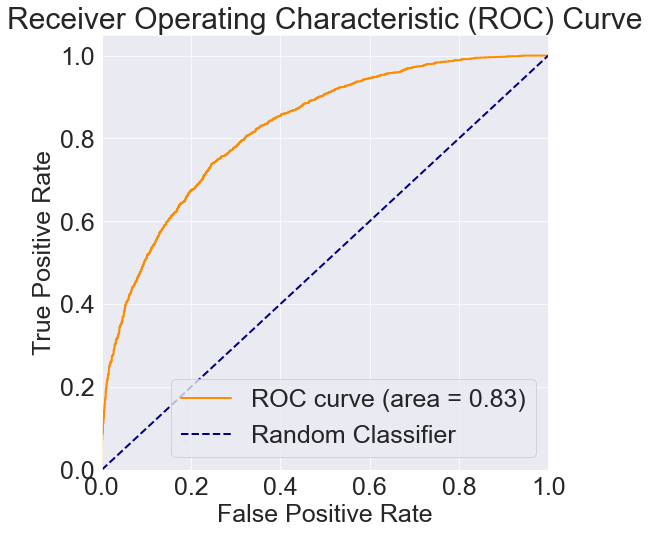

In [177]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
 
# Plot ROC curve for random classifier
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

# Set the limits of the plot to include both curves
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the axis labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()

Feature importance and SHAP values for the best model

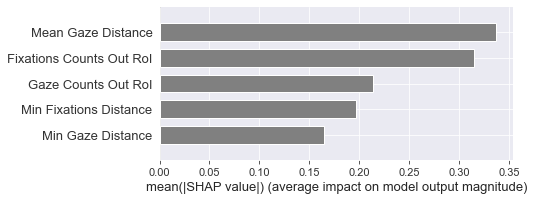

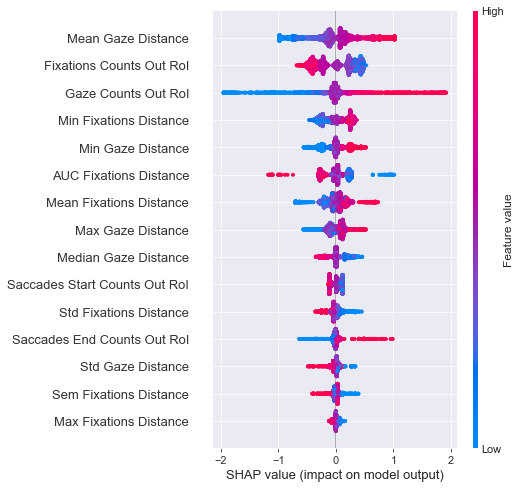

<Figure size 432x288 with 0 Axes>

In [178]:
import shap
import matplotlib.pyplot as plt

%matplotlib inline

# Create object that can calculate shap values
explainer = shap.TreeExplainer(xgb)

# Calculate Shap values
shap_values = explainer.shap_values(X_train_scaled)

# Increase font size
plt.rcParams.update({'font.size': 30})

# Plot summary plot (feature importance) with the top 15 features in gray color
shap.summary_plot(shap_values, X_train_scaled, plot_type="bar", max_display=5, color='gray')

# mark the features that has the suffix '_Distance' in their name with astrisk
# X_train_scaled.columns = ['* ' + col if col.endswith('Distance') else col for col in X_train_scaled.columns]

# Plot summary plot with the top 17 features
plt.figure(figsize=(16, 10))
shap.summary_plot(shap_values, X_train_scaled, max_display=15)

# Save the plot
plt.savefig(os.path.join(config.classification_resource_dir, "shap_values.png"))

Study example use cases using shap force plots

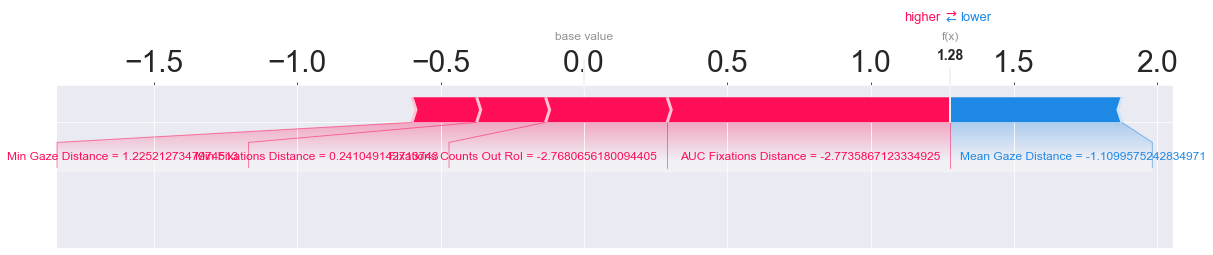

In [182]:
# Select a specific instance (e.g., the first instance)
instance_index = 0
shap_values_instance = shap_values[instance_index]
X_test_instance = X_train_scaled.iloc[instance_index]

# Get the indices of the features with the top 5 absolute SHAP values
top_indices = np.argsort(np.abs(shap_values_instance))[-5:]

# Create new SHAP values and feature arrays that only include these top 5 features
shap_values_top = shap_values_instance[top_indices]
X_test_top = X_test_instance.iloc[top_indices]

# Plot the SHAP force plot for the instance
shap.force_plot(explainer.expected_value, shap_values_top, X_test_top, matplotlib=True)

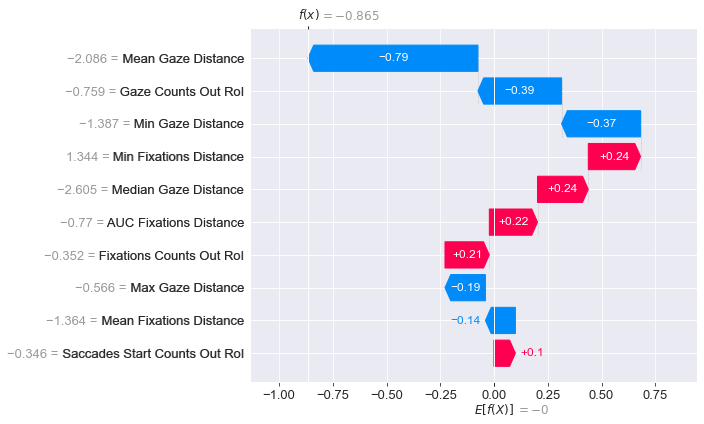

True label: 0
Pred label: 0


In [192]:
# Select a specific instance (e.g., the first instance)
instance_index = 15
shap_values_instance = shap_values[instance_index]
X_test_instance = X_train_scaled.iloc[instance_index]

# Get the indices of the features with the top 10 absolute SHAP values
top_indices = np.argsort(np.abs(shap_values_instance))[-10:]

# Create new SHAP values and feature arrays that only include these top 10 features
shap_values_top = shap_values_instance[top_indices]
X_test_top = X_test_instance.iloc[top_indices]

# Plot the SHAP waterfall plot for the instance
shap.plots.waterfall(shap.Explanation(values=shap_values_top, base_values=explainer.expected_value, data=X_test_top))

# print the true label of the instance
print(f"True label: {y_train[instance_index]}")
# print the pred label of the instance
print(f"Pred label: {xgb.predict(X_test_instance.values.reshape(1, -1))[0]}")